# Text autorship identification

For this prove, we will test ideas to feature extraction and data pre-processing that will be taken from two papers found in arxiv:

[1] [TEXT CLASSIFICATION FOR AUTHORSHIP
ATTRIBUTION ANALYSIS](https://arxiv.org/pdf/1310.4909.pdf)

[2] [A Machine Learning Framework for Authorship Identification From Texts](https://arxiv.org/pdf/1912.10204.pdf)

In our tests, we will check how the accuracy of our final model behaves when presented to these ideas.

This notebook is part of a practical prove provided from NUVEO.

### Imports

For the purpose of this task, the following libraries will be helping us to present the ideas through this notebook.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import re 
import string

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/joao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/joao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/joao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
train_data_csv = './TrainingSet/text-authorship-training.csv'
test_data_csv = './TestSet/text-authorship-test.csv'

### Data train reading

In [3]:
author_data = pd.read_csv(train_data_csv)
author_data.head()

,id,text,author
0,id15709,The occupation is often full of interest and h...,EAP
1,id18229,"Tall, thin, and strait, her face still handsom...",MWS
2,id10092,"What men attempt to embody in the word ""though...",EAP
3,id05976,They will scarcely be so weak as not to 'reali...,EAP
4,id19298,"There dwelt in that ghastly and flexible face,...",HPL


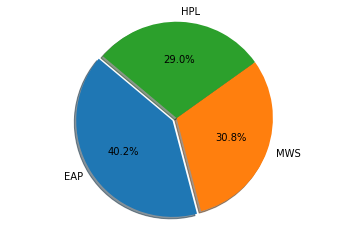

In [4]:
labels = 'EAP','MWS','HPL'
author_data['author'].value_counts()

sizes = list(author_data['author'].value_counts())

explode=(0.05, 0, 0)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, shadow=True,autopct='%1.1f%%', startangle=140)
ax.axis('equal')
plt.show()

As we can see, the authors distribution looks be very balanced

### Feature Extraction

As mentioned at the beginning, the main ideas for feature extraction were taken from two papers. From the first one, we will take features that involve punctuation and features related directly to the text and letters. From the second one, we will count the occurrence of certain words. To sum up, here it is the features that we will implement:

**Punctuation and Phraseology:**

- Number of periods
- Number of commas
- number of question marks
- Number of colons
- Number of semi-colons
- Number of blanks 
- Number of exclamation marks
- Number of dashes
- Number of underscores
- Number of brackets
- Number of words
- Number of sentences
- Number of characters

**Lexical:**
- Number of and
- Number of but
- Number of however
- Number of if
- Number of that
- Number of more
- Number of might
- Number of this
- Number of very


In [5]:
def feature_extraction_punc_phras(author_data):
    """ Extract features from punctuation and phraseology
    
    Args:
        author_data: the dataframe with the text information
    Return:
        author_data: the dataframe that now contains the new features
    """
    
    author_data['num_periods'] = author_data['text'].apply(lambda x: x.count('.'))
    author_data['num_commas'] = author_data['text'].apply(lambda x: x.count(','))
    author_data['num_questions'] = author_data['text'].apply(lambda x: x.count('?'))
    author_data['num_colons'] = author_data['text'].apply(lambda x: x.count(':'))
    author_data['num_semi-colons'] = author_data['text'].apply(lambda x: x.count(';'))
    author_data['num_blanks'] = author_data['text'].apply(lambda x: x.count(' '))
    author_data['num_exclamation'] = author_data['text'].apply(lambda x: x.count('!'))
    author_data['num_dashes'] = author_data['text'].apply(lambda x: x.count('-'))
    author_data['num_underscores'] = author_data['text'].apply(lambda x: x.count('_'))
    author_data['num_brackets'] = author_data['text'].apply(lambda x: x.count('[') * 2)
    
    author_data['num_words'] = author_data['text'].apply(lambda x: len(x.split(' ')))
    author_data['num_sentences'] = author_data['text'].apply(lambda x: len(sent_tokenize(x)))
    author_data['num_characters'] = author_data['text'].apply(lambda x: len(x) - x.count(" "))
    author_data['lexical_diff'] = author_data['text'].apply(lambda x: len(x)/len(set(x)))
    return author_data

def feature_extraction_lexical(author_data):
    """ Extract features from lexical
    Args:
        author_data: the dataframe with the text information
    Return:
        author_data: the dataframe that now contains the new features
    """
    lexical_terms = ["and", "but", "however","if","that","more","might","this","very"]
    
    for lexical in lexical_terms:
        author_data[f'num_of_{lexical}'] = author_data['text'].apply(lambda x: x.count(lexical))
    
    return author_data

After all feature extraction, our data now looks like this:

In [6]:
author_data = feature_extraction_punc_phras(author_data)
author_data = feature_extraction_lexical(author_data)
author_data.head()

,id,text,author,num_periods,num_commas,num_questions,num_colons,num_semi-colons,num_blanks,num_exclamation,...,lexical_diff,num_of_and,num_of_but,num_of_however,num_of_if,num_of_that,num_of_more,num_of_might,num_of_this,num_of_very
0,id15709,The occupation is often full of interest and h...,EAP,1,0,0,0,0,31,0,...,8.347826,3,0,0,0,0,0,0,0,0
1,id18229,"Tall, thin, and strait, her face still handsom...",MWS,1,7,0,0,0,40,0,...,8.923077,3,0,0,1,0,0,0,0,0
2,id10092,"What men attempt to embody in the word ""though...",EAP,1,1,0,0,0,13,0,...,3.409091,0,0,0,0,0,0,0,1,0
3,id05976,They will scarcely be so weak as not to 'reali...,EAP,1,3,0,0,0,24,0,...,4.928571,2,0,0,0,0,0,0,0,0
4,id19298,"There dwelt in that ghastly and flexible face,...",HPL,1,6,0,0,0,37,0,...,8.185185,3,0,0,0,1,1,0,0,0


### Data Pre-processing

Following the ideas from both papers, to process our data we will use 3 methods:

**1. Tokenization:** Tokenization is the method of splitting a stream of text into meaningful elements. For us, these meaningful elements will be taken following the stopwords/punctuation idea, in other words, only not stopwords/punctuation will continue in our stream of text. We also will put all words in lower case.

**2. Stemming:** Stemming is the process of reducing the inflected words to their root or base form known as the stem.
The stem may not be the same as the morphological root of that word. [1] uses WordNet for stemming. This stemmer adds functionality to the simple pattern-based stemmer SimpleStemmer by checking to see if possible stems are actually present in Wordnet. 

**3. Top K Words:** Mapping all words present in the dataset, build a corpus which, this corpus, contains the frequency of each word.

In [7]:
def tokenize_normalization(message):
    """ Applying tokenization and filtering the message
         excluding punctuation and stopwords
    Args:
        message: text string
    Returns:
        return a cleaner message
    """
    stopwords.words('english')
    word_tokens = word_tokenize(message) 
    filtered_stop = [word for word in word_tokens if not word in stopwords.words('english')]
    filtered_punctuation = [word for word in filtered_stop if not word in string.punctuation]

    return " ".join([word.lower() for word in filtered_punctuation])
    
def stemming_normalization(message):
    """Stemming the given message using WordNetLemmatizer()
    Args:
        message: text string
    Returns:
        return a stemmed sentence
    """
    wnl = nltk.WordNetLemmatizer()
    splited_message = message.split()
    
    return " ".join([wnl.lemmatize(word) for word in splited_message])

#### Applying Tokenization

In [8]:
author_data['tokenized_text'] = author_data['text'].apply(lambda x: tokenize_normalization(x))
author_data.head()

,id,text,author,num_periods,num_commas,num_questions,num_colons,num_semi-colons,num_blanks,num_exclamation,...,num_of_and,num_of_but,num_of_however,num_of_if,num_of_that,num_of_more,num_of_might,num_of_this,num_of_very,tokenized_text
0,id15709,The occupation is often full of interest and h...,EAP,1,0,0,0,0,31,0,...,3,0,0,0,0,0,0,0,0,the occupation often full interest attempts fi...
1,id18229,"Tall, thin, and strait, her face still handsom...",MWS,1,7,0,0,0,40,0,...,3,0,0,1,0,0,0,0,0,tall thin strait face still handsome raven hai...
2,id10092,"What men attempt to embody in the word ""though...",EAP,1,1,0,0,0,13,0,...,0,0,0,0,0,0,0,1,0,what men attempt embody word `` thought '' mat...
3,id05976,They will scarcely be so weak as not to 'reali...,EAP,1,3,0,0,0,24,0,...,2,0,0,0,0,0,0,0,0,they scarcely weak 'realize time large purchas...
4,id19298,"There dwelt in that ghastly and flexible face,...",HPL,1,6,0,0,0,37,0,...,3,0,0,0,1,1,0,0,0,there dwelt ghastly flexible face shone bodile...


#### Applying stemming normalization

In [9]:
author_data['stemmed_text'] = author_data['tokenized_text'].apply(lambda x: stemming_normalization(x))
author_data.head()

,id,text,author,num_periods,num_commas,num_questions,num_colons,num_semi-colons,num_blanks,num_exclamation,...,num_of_but,num_of_however,num_of_if,num_of_that,num_of_more,num_of_might,num_of_this,num_of_very,tokenized_text,stemmed_text
0,id15709,The occupation is often full of interest and h...,EAP,1,0,0,0,0,31,0,...,0,0,0,0,0,0,0,0,the occupation often full interest attempts fi...,the occupation often full interest attempt fir...
1,id18229,"Tall, thin, and strait, her face still handsom...",MWS,1,7,0,0,0,40,0,...,0,0,1,0,0,0,0,0,tall thin strait face still handsome raven hai...,tall thin strait face still handsome raven hai...
2,id10092,"What men attempt to embody in the word ""though...",EAP,1,1,0,0,0,13,0,...,0,0,0,0,0,0,1,0,what men attempt embody word `` thought '' mat...,what men attempt embody word `` thought '' mat...
3,id05976,They will scarcely be so weak as not to 'reali...,EAP,1,3,0,0,0,24,0,...,0,0,0,0,0,0,0,0,they scarcely weak 'realize time large purchas...,they scarcely weak 'realize time large purchas...
4,id19298,"There dwelt in that ghastly and flexible face,...",HPL,1,6,0,0,0,37,0,...,0,0,0,1,1,0,0,0,there dwelt ghastly flexible face shone bodile...,there dwelt ghastly flexible face shone bodile...


### Applying CountVectorizer

CountVectorizer just count the tokens over the texts and create a matrix of these N created tokens.

In [10]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(author_data.stemmed_text)
count_vect_df = pd.DataFrame(X.toarray())
count_vect_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20835,20836,20837,20838,20839,20840,20841,20842,20843,20844
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
print("At the final, vectorizer corpus has a total of {} words".format(len(count_vect_df.columns)))

At the final, vectorizer corpus has a total of 20845 words


In [12]:
final_data = pd.concat([author_data, count_vect_df], axis=1, sort=False)
final_data.drop(['author','text','id','tokenized_text','stemmed_text'], axis=1, inplace=True)
final_data.head()

,num_periods,num_commas,num_questions,num_colons,num_semi-colons,num_blanks,num_exclamation,num_dashes,num_underscores,num_brackets,...,20835,20836,20837,20838,20839,20840,20841,20842,20843,20844
0,1,0,0,0,0,31,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7,0,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,24,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,6,0,0,0,37,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As we need to fill in  an entire set of new data (and as this test is alway dificult than the first one) our test_size fraction here will be `0.05`

In [13]:
txt_train, txt_test, label_train, label_test = train_test_split(final_data, author_data['author'], test_size=0.05)

# <span style="color:red">Note</span>

The first idea here was to test the data using SVM classifier, just like [1] did. But it was taking a long time to train and I stoped the process to try something else.

My second idea was to try to use a grid search just like I did in the [first](https://github.com/joaolcaas/cv-test/blob/JoaoFelipe/SMSSpamDetection/SMSSpamDetection.ipynb) prove. But some errors happened (i.e. memory error) and I was not able to run this type of strategy due to the (1) big data and (2) small memory at the train setup computer.

My third option was to test some models that [2] has tested, and, after some trials, NaiveBayes was 

In [14]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

model.fit(txt_train, label_train)

MultinomialNB()

In [15]:
clf_prediction = model.predict(txt_test)
print("Accuracy: {}".format( round((clf_prediction==label_test).sum() / len(clf_prediction),3)))

Accuracy: 0.848


In [16]:
# due memory error
del txt_train
del txt_test
del label_train
del label_test
del final_data

### Filling in the testset

Now, all we did before train our train data, we will do the same in the test data. 

In [17]:
test_set = pd.read_csv(test_data_csv)
test_set.head()

,id,text
0,id26305,"This process, however, afforded me no means of..."
1,id17569,It never once occurred to me that the fumbling...
2,id11008,"In his left hand was a gold snuff box, from wh..."
3,id27763,How lovely is spring As we looked from Windsor...
4,id12958,"Finding nothing else, not even gold, the Super..."


In [18]:
test_set = feature_extraction_punc_phras(test_set)
test_set = feature_extraction_lexical(test_set)
test_set.head()

,id,text,num_periods,num_commas,num_questions,num_colons,num_semi-colons,num_blanks,num_exclamation,num_dashes,...,lexical_diff,num_of_and,num_of_but,num_of_however,num_of_if,num_of_that,num_of_more,num_of_might,num_of_this,num_of_very
0,id26305,"This process, however, afforded me no means of...",1,4,0,0,2,40,0,0,...,8.250000,1,0,1,1,0,0,1,0,0
1,id17569,It never once occurred to me that the fumbling...,1,0,0,0,0,13,0,0,...,3.227273,0,0,0,0,1,0,1,0,0
2,id11008,"In his left hand was a gold snuff box, from wh...",1,4,0,0,0,35,0,0,...,7.692308,1,0,0,0,0,0,0,0,0
3,id27763,How lovely is spring As we looked from Windsor...,1,3,0,0,0,33,0,0,...,6.866667,2,0,0,0,0,0,0,0,0
4,id12958,"Finding nothing else, not even gold, the Super...",1,2,0,0,1,26,0,0,...,6.444444,1,1,0,0,0,0,0,0,0


In [19]:
test_set['tokenized_text'] = test_set['text'].apply(lambda x: tokenize_normalization(x))
test_set.head()

,id,text,num_periods,num_commas,num_questions,num_colons,num_semi-colons,num_blanks,num_exclamation,num_dashes,...,num_of_and,num_of_but,num_of_however,num_of_if,num_of_that,num_of_more,num_of_might,num_of_this,num_of_very,tokenized_text
0,id26305,"This process, however, afforded me no means of...",1,4,0,0,2,40,0,0,...,1,0,1,1,0,0,1,0,0,this process however afforded means ascertaini...
1,id17569,It never once occurred to me that the fumbling...,1,0,0,0,0,13,0,0,...,0,0,0,0,1,0,1,0,0,it never occurred fumbling might mere mistake
2,id11008,"In his left hand was a gold snuff box, from wh...",1,4,0,0,0,35,0,0,...,1,0,0,0,0,0,0,0,0,in left hand gold snuff box capered hill cutti...
3,id27763,How lovely is spring As we looked from Windsor...,1,3,0,0,0,33,0,0,...,2,0,0,0,0,0,0,0,0,how lovely spring as looked windsor terrace si...
4,id12958,"Finding nothing else, not even gold, the Super...",1,2,0,0,1,26,0,0,...,1,1,0,0,0,0,0,0,0,finding nothing else even gold superintendent ...


In [20]:
test_set['stemmed_text'] = test_set['tokenized_text'].apply(lambda x: stemming_normalization(x))
test_set.head()

,id,text,num_periods,num_commas,num_questions,num_colons,num_semi-colons,num_blanks,num_exclamation,num_dashes,...,num_of_but,num_of_however,num_of_if,num_of_that,num_of_more,num_of_might,num_of_this,num_of_very,tokenized_text,stemmed_text
0,id26305,"This process, however, afforded me no means of...",1,4,0,0,2,40,0,0,...,0,1,1,0,0,1,0,0,this process however afforded means ascertaini...,this process however afforded mean ascertainin...
1,id17569,It never once occurred to me that the fumbling...,1,0,0,0,0,13,0,0,...,0,0,0,1,0,1,0,0,it never occurred fumbling might mere mistake,it never occurred fumbling might mere mistake
2,id11008,"In his left hand was a gold snuff box, from wh...",1,4,0,0,0,35,0,0,...,0,0,0,0,0,0,0,0,in left hand gold snuff box capered hill cutti...,in left hand gold snuff box capered hill cutti...
3,id27763,How lovely is spring As we looked from Windsor...,1,3,0,0,0,33,0,0,...,0,0,0,0,0,0,0,0,how lovely spring as looked windsor terrace si...,how lovely spring a looked windsor terrace six...
4,id12958,"Finding nothing else, not even gold, the Super...",1,2,0,0,1,26,0,0,...,1,0,0,0,0,0,0,0,finding nothing else even gold superintendent ...,finding nothing else even gold superintendent ...


In [21]:
X_test = vectorizer.transform(test_set.stemmed_text)
vector_test = pd.DataFrame(X_test.toarray())
vector_test.head()

,0,1,2,3,4,5,6,7,8,9,...,20835,20836,20837,20838,20839,20840,20841,20842,20843,20844
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
test_set.drop(['stemmed_text'],axis=1, inplace=True)
final_data_test = pd.concat([test_set, vector_test], axis=1, sort=False)
final_data_test.drop(['text','id','tokenized_text'], axis=1, inplace=True)
final_data_test.head()

,num_periods,num_commas,num_questions,num_colons,num_semi-colons,num_blanks,num_exclamation,num_dashes,num_underscores,num_brackets,...,20835,20836,20837,20838,20839,20840,20841,20842,20843,20844
0,1,4,0,0,2,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,0,0,0,35,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,33,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2,0,0,1,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
final_set = {"author":[],"text":test_set.text}

In [24]:
final_data_test

,num_periods,num_commas,num_questions,num_colons,num_semi-colons,num_blanks,num_exclamation,num_dashes,num_underscores,num_brackets,...,20835,20836,20837,20838,20839,20840,20841,20842,20843,20844
0,1,4,0,0,2,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,0,0,0,35,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,33,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2,0,0,1,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2930,1,2,0,0,0,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2931,0,0,1,0,0,17,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2932,1,1,0,0,0,28,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2933,1,0,0,0,0,19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After all, we can make the predictions and fill in the testset

In [25]:
predictions = model.predict(final_data_test)

In [26]:
final_set["author"] = predictions
final_ans = pd.DataFrame(final_set)
final_ans.to_csv('final_ans.csv', index=False)
final_ans.head()

,author,text
0,EAP,"This process, however, afforded me no means of..."
1,EAP,It never once occurred to me that the fumbling...
2,EAP,"In his left hand was a gold snuff box, from wh..."
3,MWS,How lovely is spring As we looked from Windsor...
4,EAP,"Finding nothing else, not even gold, the Super..."
